In [33]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'/Users/Sohail/Desktop/io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

In [34]:
# Read data from prometheus
# don't do it if csv is already populated
# to get epoch date --date='Sun 21 Apr 2019 12:25:24 GMT' +"%s"
end_time = int('1555849524')
hrs = 7.5
start_time = int(end_time - 60*60*hrs)
result = run_query_range(Queries["io_util"], start_time, end_time, 10)
hosts = {x[0] for x in result}
response = {}
for host in hosts:
    response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]
    
values = response[Nodes["k8node"]]

write_to_file(("TIME", "UTIL"))
XY = []
for x, y in values:
    XY.append((x, y))
    write_to_file( (x, y) )

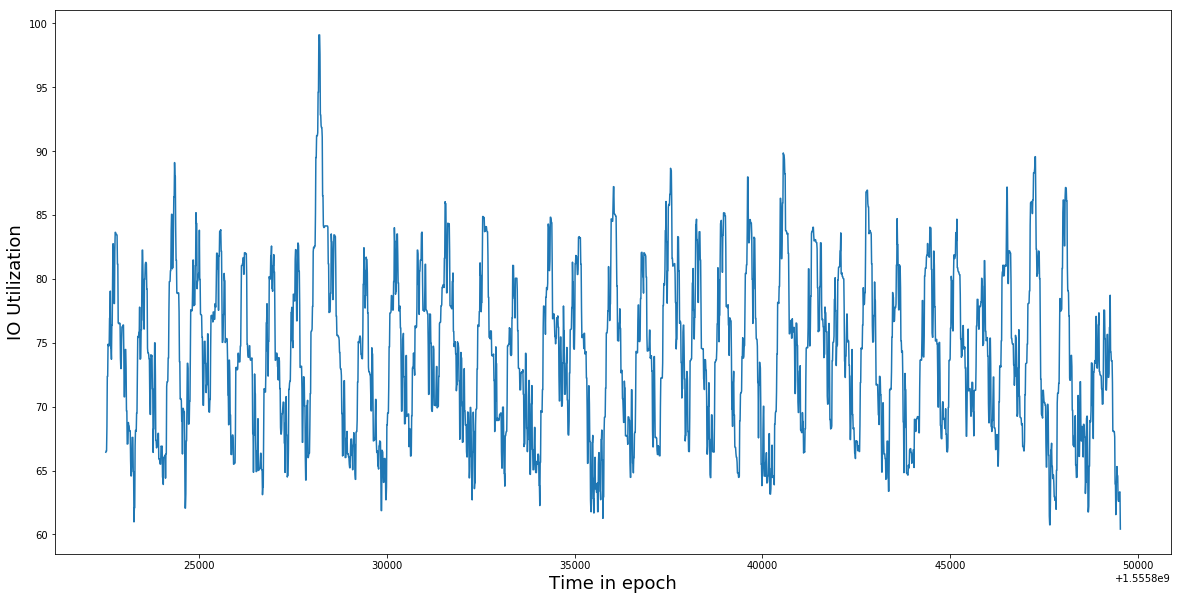

In [35]:
dataframe1 = pd.read_csv('/Users/Sohail/Desktop/io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [36]:
import itertools
p=d=q=range(0,10)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
pdqTrunc = [x for x in pdq if x[1] < 5 and x[2] < 5]

In [37]:
aicVal = []
for param in pdqTrunc:
    try:
        model_arima = ARIMA(y1, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
        aicVal.append((param, model_arima_fit.aic))
    except:
        continue

(0, 0, 0) 17635.32246231514
(0, 0, 1) 15029.116633440128
(0, 0, 3) 12129.359478044677
(0, 1, 0) 10939.247704975081
(0, 1, 1) 10907.612588954711
(0, 1, 2) 10697.02035162101
(0, 1, 3) 10587.508283659154
(0, 1, 4) 10554.583659140164
(0, 2, 0) 12433.943120772168
(0, 2, 1) 10945.947481900661
(0, 2, 2) 10914.164353361053
(0, 2, 3) 10702.983101781041
(1, 0, 0) 10892.48237963879
(1, 0, 1) 10849.962843382757
(1, 0, 2) 10580.40606952635
(1, 0, 3) 10532.948378499217
(1, 0, 4) 10511.939849801292
(1, 1, 0) 10896.175965353359
(1, 1, 1) 10891.145724464957
(1, 1, 2) 10631.835347687516
(1, 1, 3) 10544.823703592801
(1, 1, 4) 10542.907846079865
(1, 2, 0) 11624.408188803145
(1, 2, 1) 10902.64620706771
(1, 2, 2) 10930.972817216576
(2, 0, 0) 10830.79967516521
(2, 0, 1) 10819.415971621438
(2, 0, 2) 10547.601044381996
(2, 0, 3) 10503.55147807873
(2, 0, 4) 10502.483166853748
(2, 1, 0) 10851.19735626947
(2, 1, 1) 10725.996234745215
(2, 1, 2) 10632.934410509002
(2, 1, 3) 10525.642600576546
(2, 1, 4) 10408.411165

In [40]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1]);

In [45]:
aicVal2[0:10]

[((8, 0, 4), 10207.127994238517),
 ((9, 0, 3), 10216.205135583734),
 ((7, 0, 3), 10217.824192706637),
 ((7, 0, 4), 10218.141290131442),
 ((8, 0, 3), 10218.89206067531),
 ((7, 0, 2), 10219.06090740463),
 ((6, 0, 4), 10219.793880423367),
 ((6, 0, 2), 10222.415969610785),
 ((5, 0, 4), 10223.432734662094),
 ((5, 0, 3), 10224.770911314296)]

In [107]:
split_percent = 0.8448
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

420
2281


In [118]:
predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[i:i+train_samples]
    model_arima = ARIMA(Y_Train, order=(5, 0, 3))
    model_arima_fit = model_arima.fit()
    predictions.append(model_arima_fit.forecast(steps=6)[0][5])

In [119]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

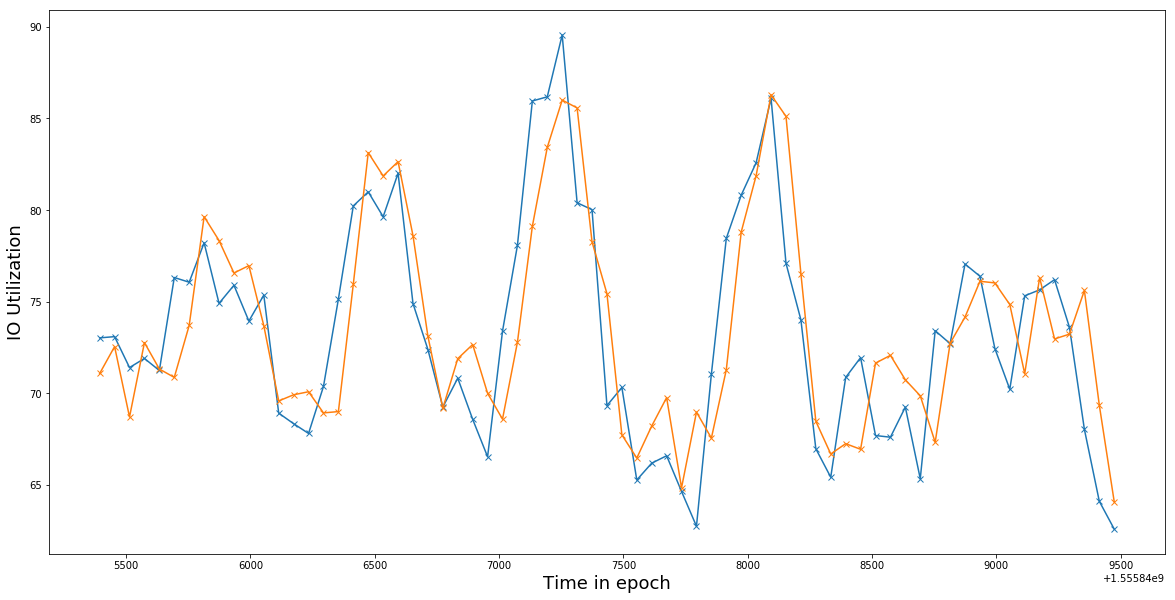

In [120]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, predictions[0:-1], {'marker': 'x'})

In [121]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred): 
    return sqrt(mean_squared_error(y_true, y_pred))

In [122]:
rmse(Y_Test, predictions[0:-1])

3.5604840753307827

In [123]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [124]:
mean_absolute_percentage_error(Y_Test, predictions[0:-1])

3.984314912233765